In [1]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks, regularizers  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0 # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

import warnings
warnings.filterwarnings('ignore')

In [2]:
testpath= "C:/Users/hp/Downloads/pro11/E-Waste classification dataset/modified-dataset/test"
trainpath= "C:/Users/hp/Downloads/pro11/E-Waste classification dataset/modified-dataset/train"
validpath = "C:/Users/hp/Downloads/pro11/E-Waste classification dataset/modified-dataset/val"

In [3]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (256,256), batch_size = 20, validation_split= False)

Found 2400 files belonging to 10 classes.


In [4]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (256,256), batch_size = 20, validation_split= False)

Found 300 files belonging to 10 classes.


In [5]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (256,256), batch_size = 20, validation_split= False)

Found 300 files belonging to 10 classes.


In [6]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


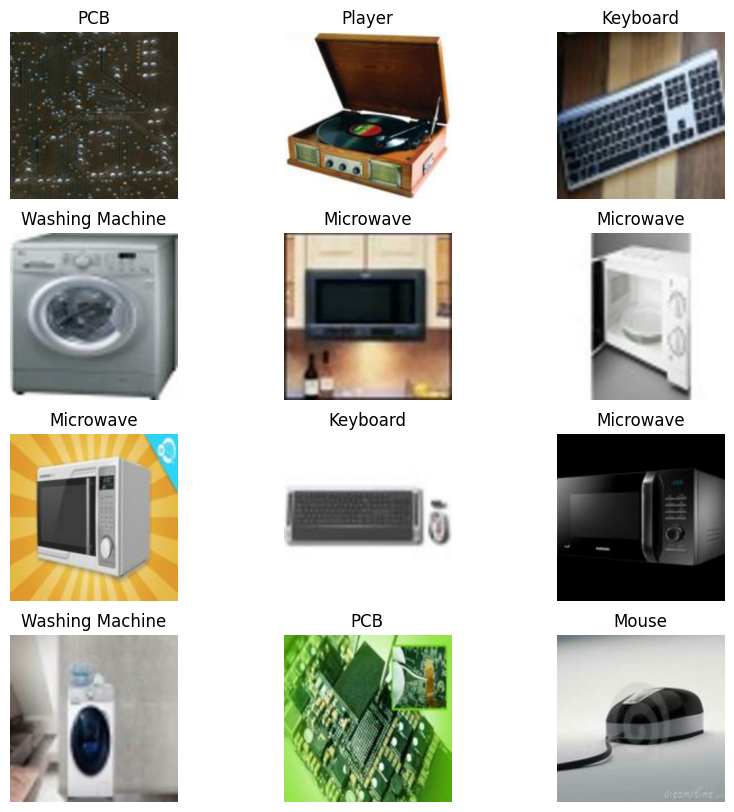

In [7]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [8]:
import matplotlib.pyplot as plt

def plot_class_distribution(dataset, title="Class Distribution"):
    class_counts = {}  # Dictionary to hold the count of each class
    
    # Iterate through the batches in the dataset
    for images, labels in dataset:
        for label in labels.numpy():  # Convert tensor to NumPy
            class_name = dataset.class_names[label]  # Map index to class name
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Now move these lines inside the function
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())
    
    # Plotting the class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts, color='red')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


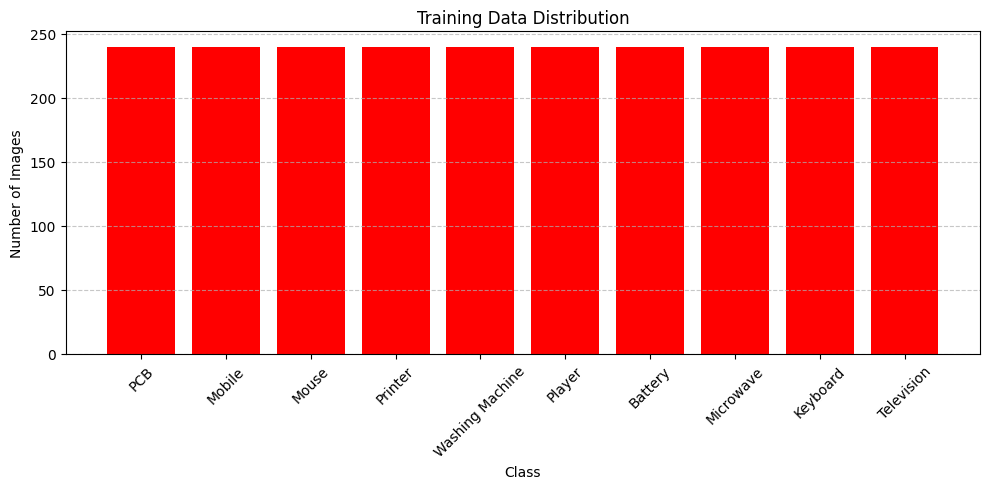

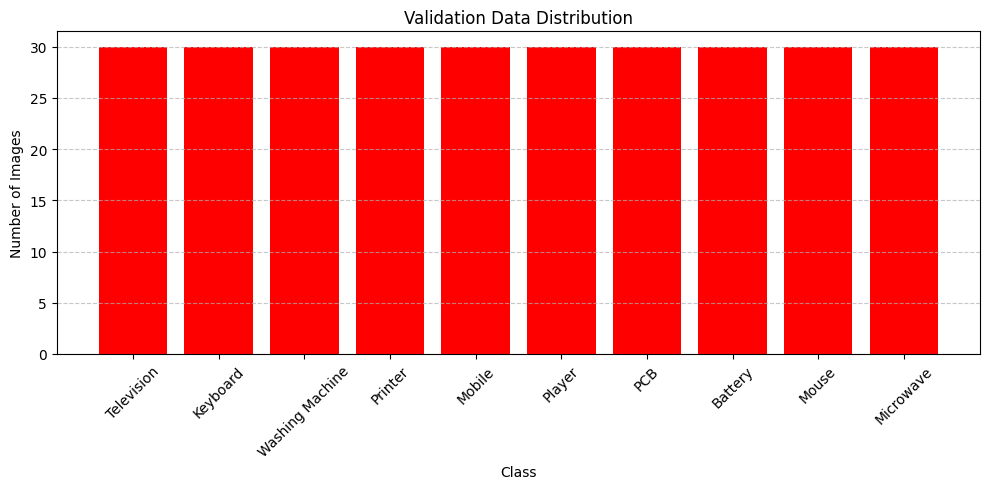

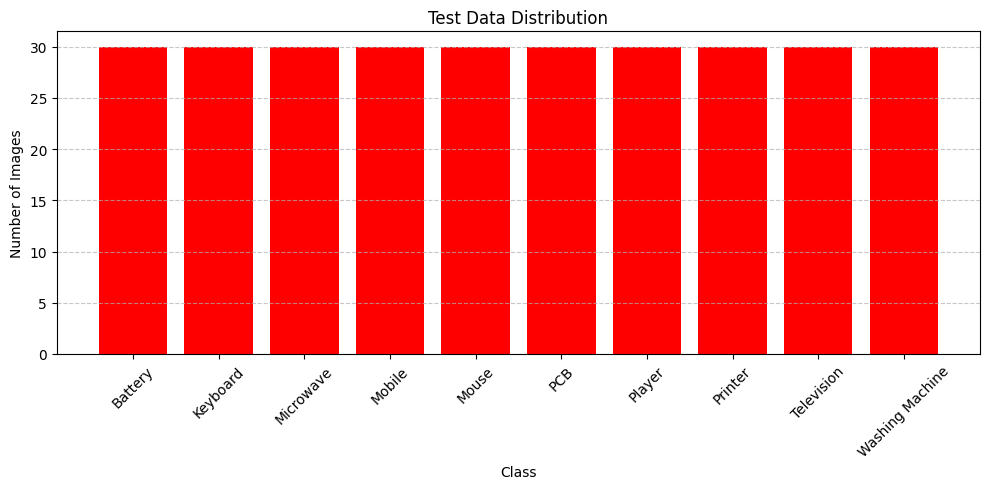

In [9]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])
import warnings
warnings.filterwarnings('ignore')

In [11]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(256,256, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:30]:
    layer.trainable = False

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256,256, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [13]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=5,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3, 
    patience=2
)

In [14]:
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    
    epochs=15,                  # Number of training epochs
    batch_size=80,                 # Number of samples per gradient update
    callbacks=[early, reduce_lr]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/15


120/120 [==============================] - 225s 2s/step - loss: 6.0698 - Accuracy: 0.4121 - val_loss: 5.0535 - val_Accuracy: 0.7967 - lr: 1.0000e-04
Epoch 2/15
120/120 [==============================] - 195s 2s/step - loss: 4.5651 - Accuracy: 0.7788 - val_loss: 3.9324 - val_Accuracy: 0.9333 - lr: 1.0000e-04
Epoch 3/15
120/120 [==============================] - 195s 2s/step - loss: 3.8386 - Accuracy: 0.8592 - val_loss: 3.3711 - val_Accuracy: 0.9567 - lr: 1.0000e-04
Epoch 4/15
120/120 [==============================] - 196s 2s/step - loss: 3.3337 - Accuracy: 0.8833 - val_loss: 2.9345 - val_Accuracy: 0.9700 - lr: 1.0000e-04
Epoch 5/15
120/120 [==============================] - 197s 2s/step - loss: 2.8733 - Accuracy: 0.9100 - val_loss: 2.5498 - val_Accuracy: 0.9567 - lr: 1.0000e-04
Epoch 6/15
120/120 [==============================] - 199s 2s/step - loss: 2.5305 - Accuracy: 0.9196 - val_loss: 2.2348 - val_Accuracy: 0.9633 - lr: 1.0000e-04
Epoch 7/15
120/120 [==================

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 8, 8, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [16]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 32)         864       ['normalizatio

In [17]:
acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

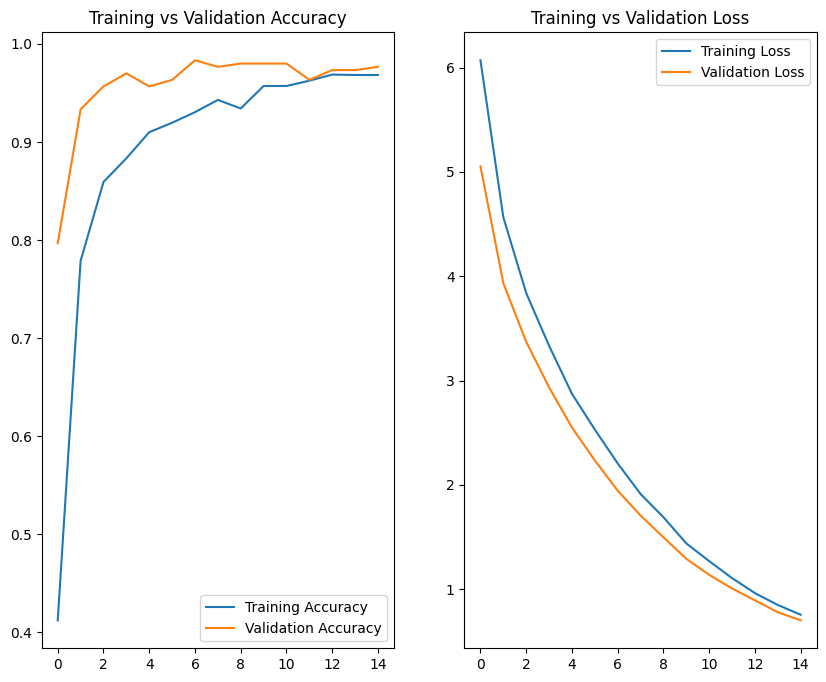

In [18]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot
plt.show()                                  # Display the plots

In [19]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

15/15 [==============================] - 8s 506ms/step - loss: 0.7192 - Accuracy: 0.9733
Test accuracy is0.9733, Test loss is 0.7192


In [20]:
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))

15/15 [==============================] - 10s 498ms/step
[[27  0  0  0  0  2  1  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  1  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0 28  2  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  1  0  0  0  0  0 29  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       1.00      1.00      1.00        30
           2       0.97      1.00      0.98        30
           3       1.00      0.97      0.98        30
           4       1.00      0.97      0.98        30
           5       0.94      1.00      0.97        30
           6       0.97      0.93      0.95        30
           7       0.91      1.00      0.95        30
           8       0.97      0.97      0.97        30
           9       1.00      1.00      1.00        30

    accuracy     

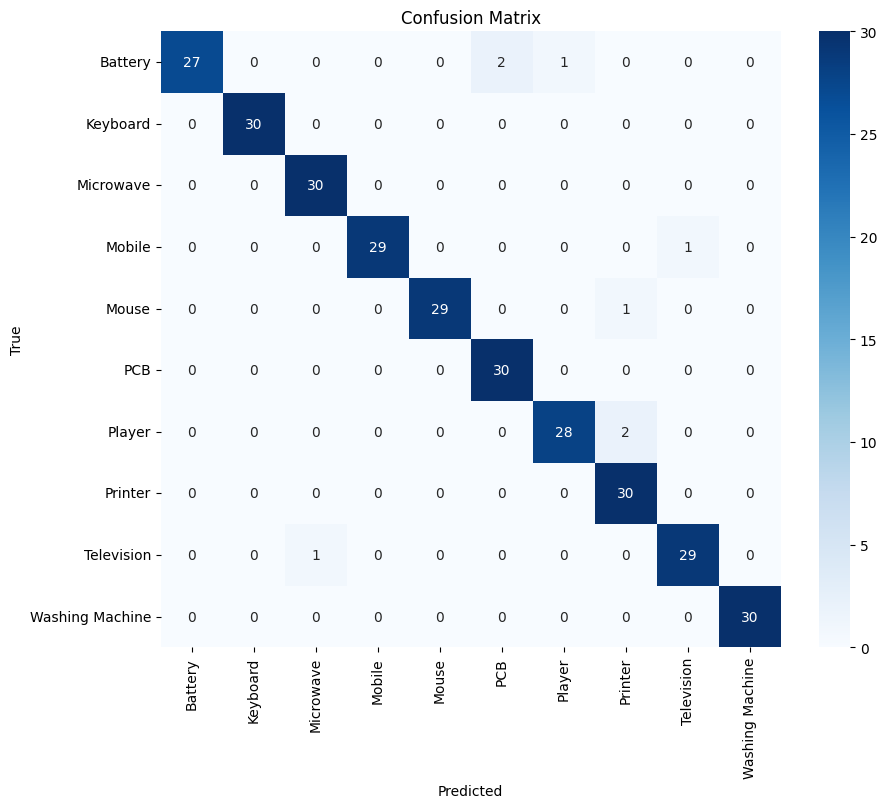

In [21]:
cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()             

1/1 [==============================] - 3s 3s/step


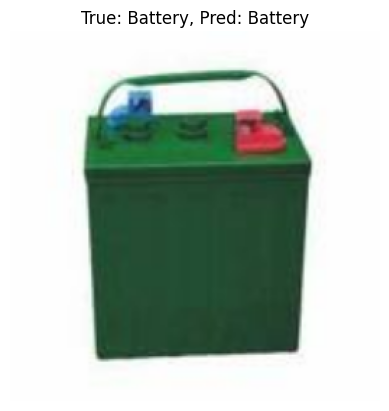

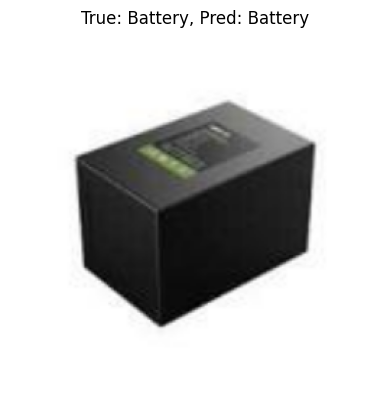

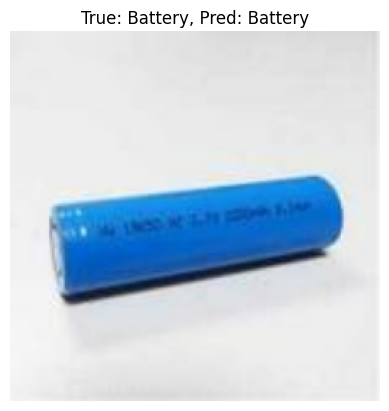

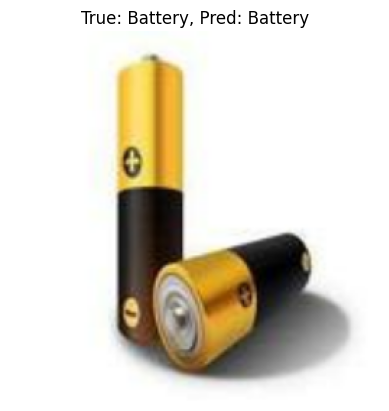

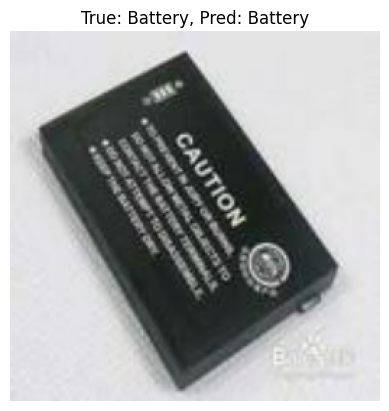

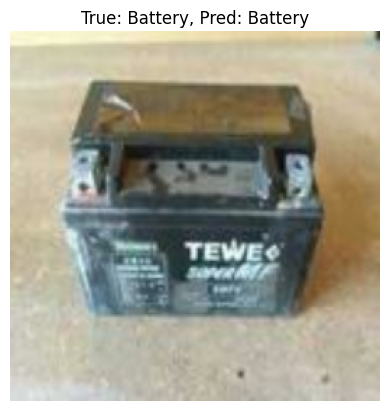

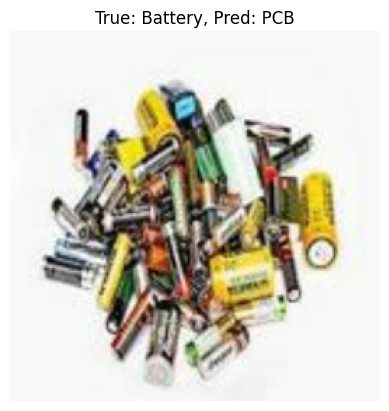

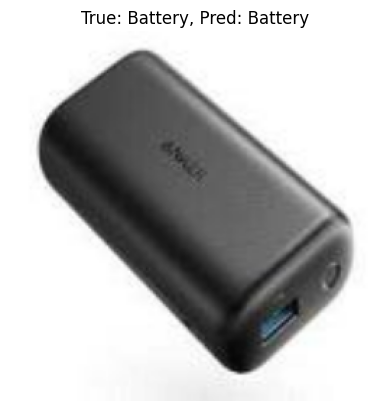

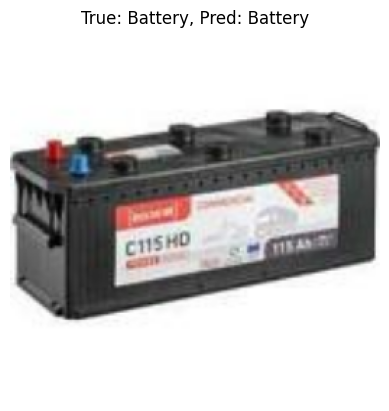

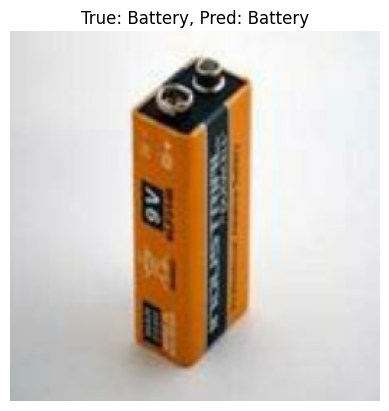

In [22]:
class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(10):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show() 

In [23]:
model.save('Efficient_classify.keras')
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [24]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((256, 256))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

In [25]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
